In [4]:
from google.colab import drive
from os import walk
import os

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import ImageFolder
import torch


path = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

#Defining tranforms for dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transforms[x]) for x in ['train', 'validation', 'test']}
train_dataset = image_datasets['train']
test_dataset =image_datasets['test']
val_dataset=image_datasets['validation']

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, num_workers=2)

In [8]:
from torchvision import models
import torch.nn as nn
num_classes = 15

model_resnet=models.resnet18(pretrained=False)

model_vggnet=models.vgg16(pretrained=False)

model_alexnet=models.alexnet(pretrained=False)

model_vggnet.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(512, num_classes))

model_alexnet.classifier[6] = nn.Linear(4096, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer_resnet=torch.optim.Adam(model_resnet.parameters(),lr=0.01)
optimizer_vggnet=torch.optim.Adam(model_vggnet.parameters(),lr=0.01)
optimizer_alexnet=torch.optim.Adam(model_alexnet.parameters(),lr=0.01)

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("Using GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using GPU


In [11]:
from tqdm.notebook import tqdm_notebook
import time

def train(model,optimizer,num_epochs,train_dl,valid_dl,train_data_percent,model_name):
    model.to(device)
    max_acc=0.0
    torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
    loss_hist_train=[0]*num_epochs
    accuracy_hist_train=[0]*num_epochs
    loss_hist_valid=[0]*num_epochs
    accuracy_hist_valid=[0]*num_epochs
    no_of_batches_to_train=int(round(len(train_dl)*train_data_percent))
    t1 = time.time()
    for epoch in tqdm_notebook(range(num_epochs),desc="Number of Epochs Completed"):
        model.train()
        count=0
        for x_batch,y_batch in tqdm_notebook(train_dl,desc="Number of Training Batches Completed"):
            if train_data_percent!=1 and count>no_of_batches_to_train:
                break
            count+=1
            x_batch,y_batch=x_batch.to(device),y_batch.to(device)
            pred=model(x_batch)
            loss=loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch]+=loss.item()*y_batch.size(0)
            is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
            accuracy_hist_train[epoch]+=is_correct.sum()
        loss_hist_train[epoch]/=len(train_dl.dataset)
        accuracy_hist_train[epoch]/=len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch,y_batch in tqdm_notebook(valid_dl,desc="Number of Validation Batches Completed"):
                x_batch,y_batch=x_batch.to(device),y_batch.to(device)
                pred=model(x_batch)
                loss=loss_fn(pred,y_batch)
                loss_hist_valid[epoch]+=loss.item()*y_batch.size(0)
                is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
                accuracy_hist_valid[epoch]+=is_correct.sum()
            loss_hist_valid[epoch]/=len(valid_dl.dataset)
            accuracy_hist_valid[epoch]/=len(valid_dl.dataset)
        if accuracy_hist_valid[epoch]>max_acc:
            max_acc=accuracy_hist_valid[epoch]
            torch.save(model.state_dict(),f"best_weights_of_{model_name}.pt")
        print(f'Epoch {epoch+1} accuracy: '
               f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
               f'{accuracy_hist_valid[epoch]:.4f}')
    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    return loss_hist_train, loss_hist_valid, \
            accuracy_hist_train, accuracy_hist_valid

In [12]:
num_epochs=1
model_resnet=models.resnet18(pretrained=False)
loss_fn=nn.CrossEntropyLoss()
optimizer_resnet=torch.optim.Adam(model_resnet.parameters(),lr=0.01)
hist_resnet=train(model_resnet,optimizer_resnet,num_epochs,train_dataloader,val_dataloader,0.2,"model_resnet")

Number of Epochs Completed:   0%|          | 0/1 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/235 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Number of Validation Batches Completed:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.0933 val_accuracy: 0.0666
######## Training Finished in 1881.0764281749725 seconds ###########


In [13]:
hist_vggnet=train(model_vggnet,optimizer_vggnet,num_epochs,train_dataloader,val_dataloader,0.2,"model_vggnet")

Number of Epochs Completed:   0%|          | 0/1 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/235 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.0979 val_accuracy: 0.0682
######## Training Finished in 65.67795920372009 seconds ###########


In [14]:
hist_alexnet=train(model_alexnet,optimizer_alexnet,num_epochs,train_dataloader,val_dataloader,0.2,"model_alexnet")

Number of Epochs Completed:   0%|          | 0/1 [00:00<?, ?it/s]

Number of Training Batches Completed:   0%|          | 0/235 [00:00<?, ?it/s]

Number of Validation Batches Completed:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1 accuracy: 0.1336 val_accuracy: 0.0666
######## Training Finished in 36.983609676361084 seconds ###########


In [15]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [16]:
# Test the resnet model
y_true, y_pred = test_model(model_resnet, test_dataloader)

# Confusion matrix
conf_matrix_resnet = confusion_matrix(y_true, y_pred)
print(conf_matrix_resnet)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]]


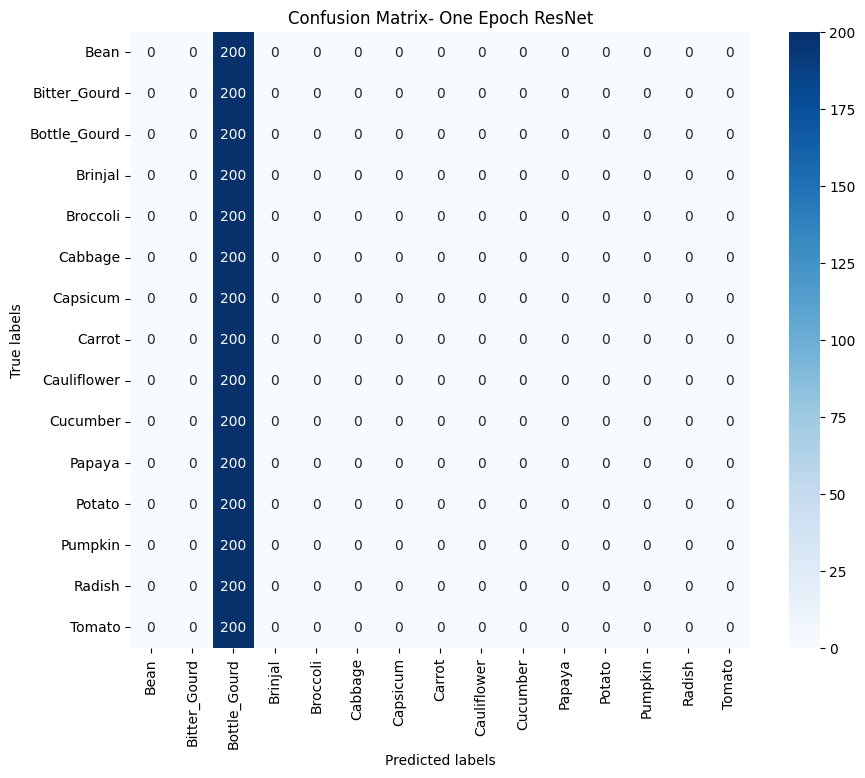

In [24]:
# Plot confusion matrix - resnet
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix- One Epoch ResNet')
plt.show()

In [18]:
train_accuracies_resnet = []
test_accuracies_resnet = []
for i in range(len(hist_resnet[2])):
    if device.type == 'cuda':
      train_accuracies_resnet.append(hist_resnet[2][i].cpu().numpy().tolist())
      test_accuracies_resnet.append(hist_resnet[3][i].cpu().numpy().tolist())
    else:
      train_accuracies_resnet.append(hist_resnet[2][i].numpy().tolist())
      test_accuracies_resnet.append(hist_resnet[3][i].numpy().tolist())

In [19]:
# Test the vggnet model
y_true, y_pred = test_model(model_vggnet, test_dataloader)

# Confusion matrix
conf_matrix_vggnet = confusion_matrix(y_true, y_pred)
print(conf_matrix_vggnet)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0   0   0   0   0   0]]


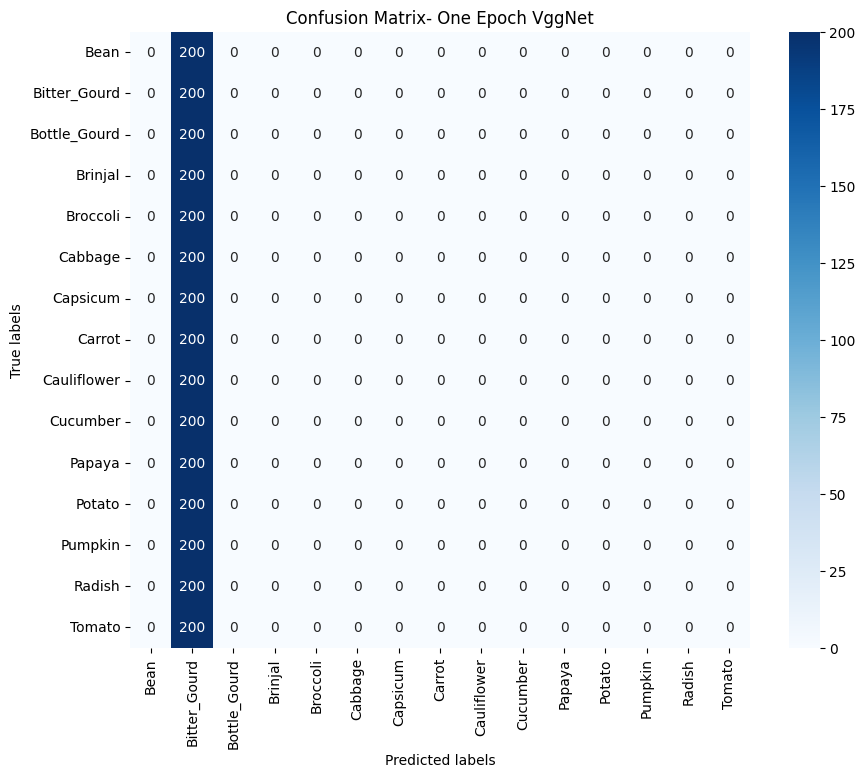

In [25]:
# Plot confusion matrix - vggnet
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_vggnet, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix- One Epoch VggNet')
plt.show()

In [26]:
train_accuracies_vggnet = []
test_accuracies_vggnet = []
for i in range(len(hist_vggnet[2])):
    if device.type == 'cuda':
      train_accuracies_vggnet.append(hist_vggnet[2][i].cpu().numpy().tolist())
      test_accuracies_vggnet.append(hist_vggnet[3][i].cpu().numpy().tolist())
    else:
      train_accuracies_vggnet.append(hist_vggnet[2][i].numpy().tolist())
      test_accuracies_vggnet.append(hist_vggnet[3][i].numpy().tolist())

In [21]:
# Test the alexnet model
y_true, y_pred = test_model(model_alexnet, test_dataloader)

# Confusion matrix
conf_matrix_alexnet = confusion_matrix(y_true, y_pred)
print(conf_matrix_alexnet)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[[  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 199   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 199   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 199   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0 199   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0   0   0   0   0]]


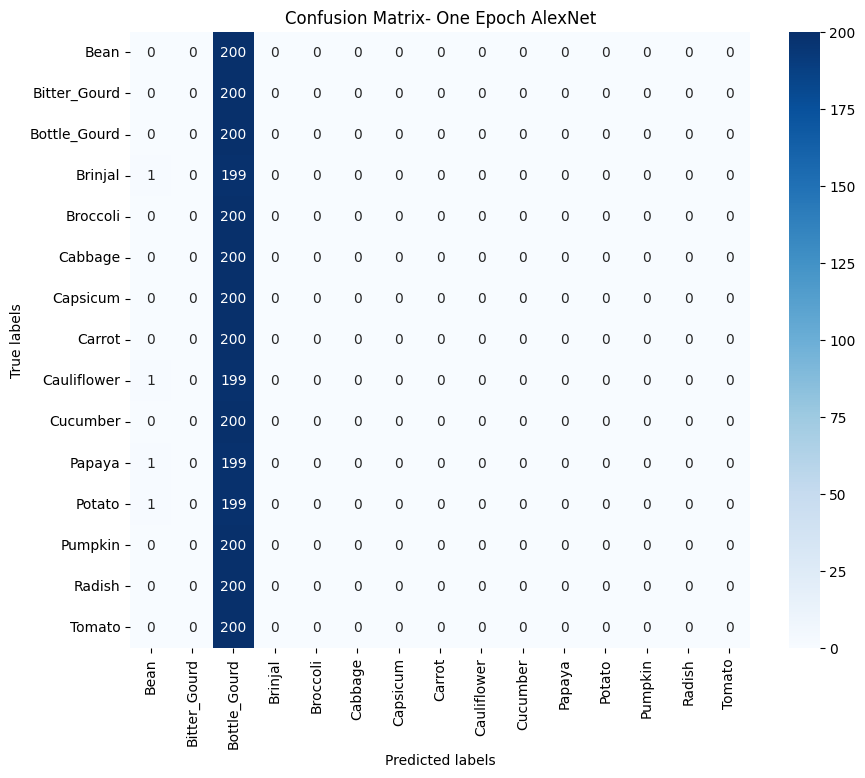

In [27]:
# Plot confusion matrix - alexnet
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_alexnet, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix- One Epoch AlexNet')
plt.show()

In [28]:
train_accuracies_alexnet = []
test_accuracies_alexnet = []
for i in range(len(hist_alexnet[2])):
    if device.type == 'cuda':
      train_accuracies_alexnet.append(hist_alexnet[2][i].cpu().numpy().tolist())
      test_accuracies_alexnet.append(hist_alexnet[3][i].cpu().numpy().tolist())
    else:
      train_accuracies_alexnet.append(hist_alexnet[2][i].numpy().tolist())
      test_accuracies_alexnet.append(hist_alexnet[3][i].numpy().tolist())

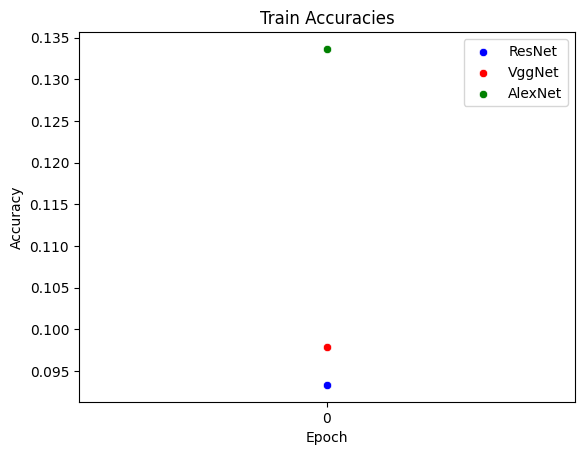

In [29]:
sns.scatterplot(x = range(num_epochs), y = train_accuracies_resnet, color = "blue", label = "ResNet")
sns.scatterplot(x = range(num_epochs), y = train_accuracies_vggnet, color = "red", label = "VggNet")
sns.scatterplot(x = range(num_epochs), y = train_accuracies_alexnet, color = "green", label = "AlexNet")
plt.title("Train Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,num_epochs))
plt.yticks(label = range(0,1))
plt.legend(loc="upper right")
plt.show()

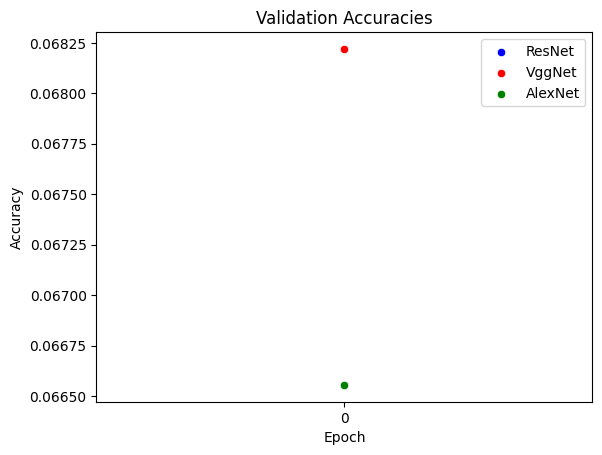

In [30]:
sns.scatterplot(x = range(num_epochs), y = test_accuracies_resnet, color = "blue", label = "ResNet")
sns.scatterplot(x = range(num_epochs), y = test_accuracies_vggnet, color = "red", label = "VggNet")
sns.scatterplot(x = range(num_epochs), y = test_accuracies_alexnet, color = "green", label = "AlexNet")
plt.title("Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(0,num_epochs))
plt.yticks(label = range(0,1))
plt.legend()
plt.show()